Starting: Loading the dataset...
Column names after stripping whitespace:
['Unnamed: 0', 'Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std

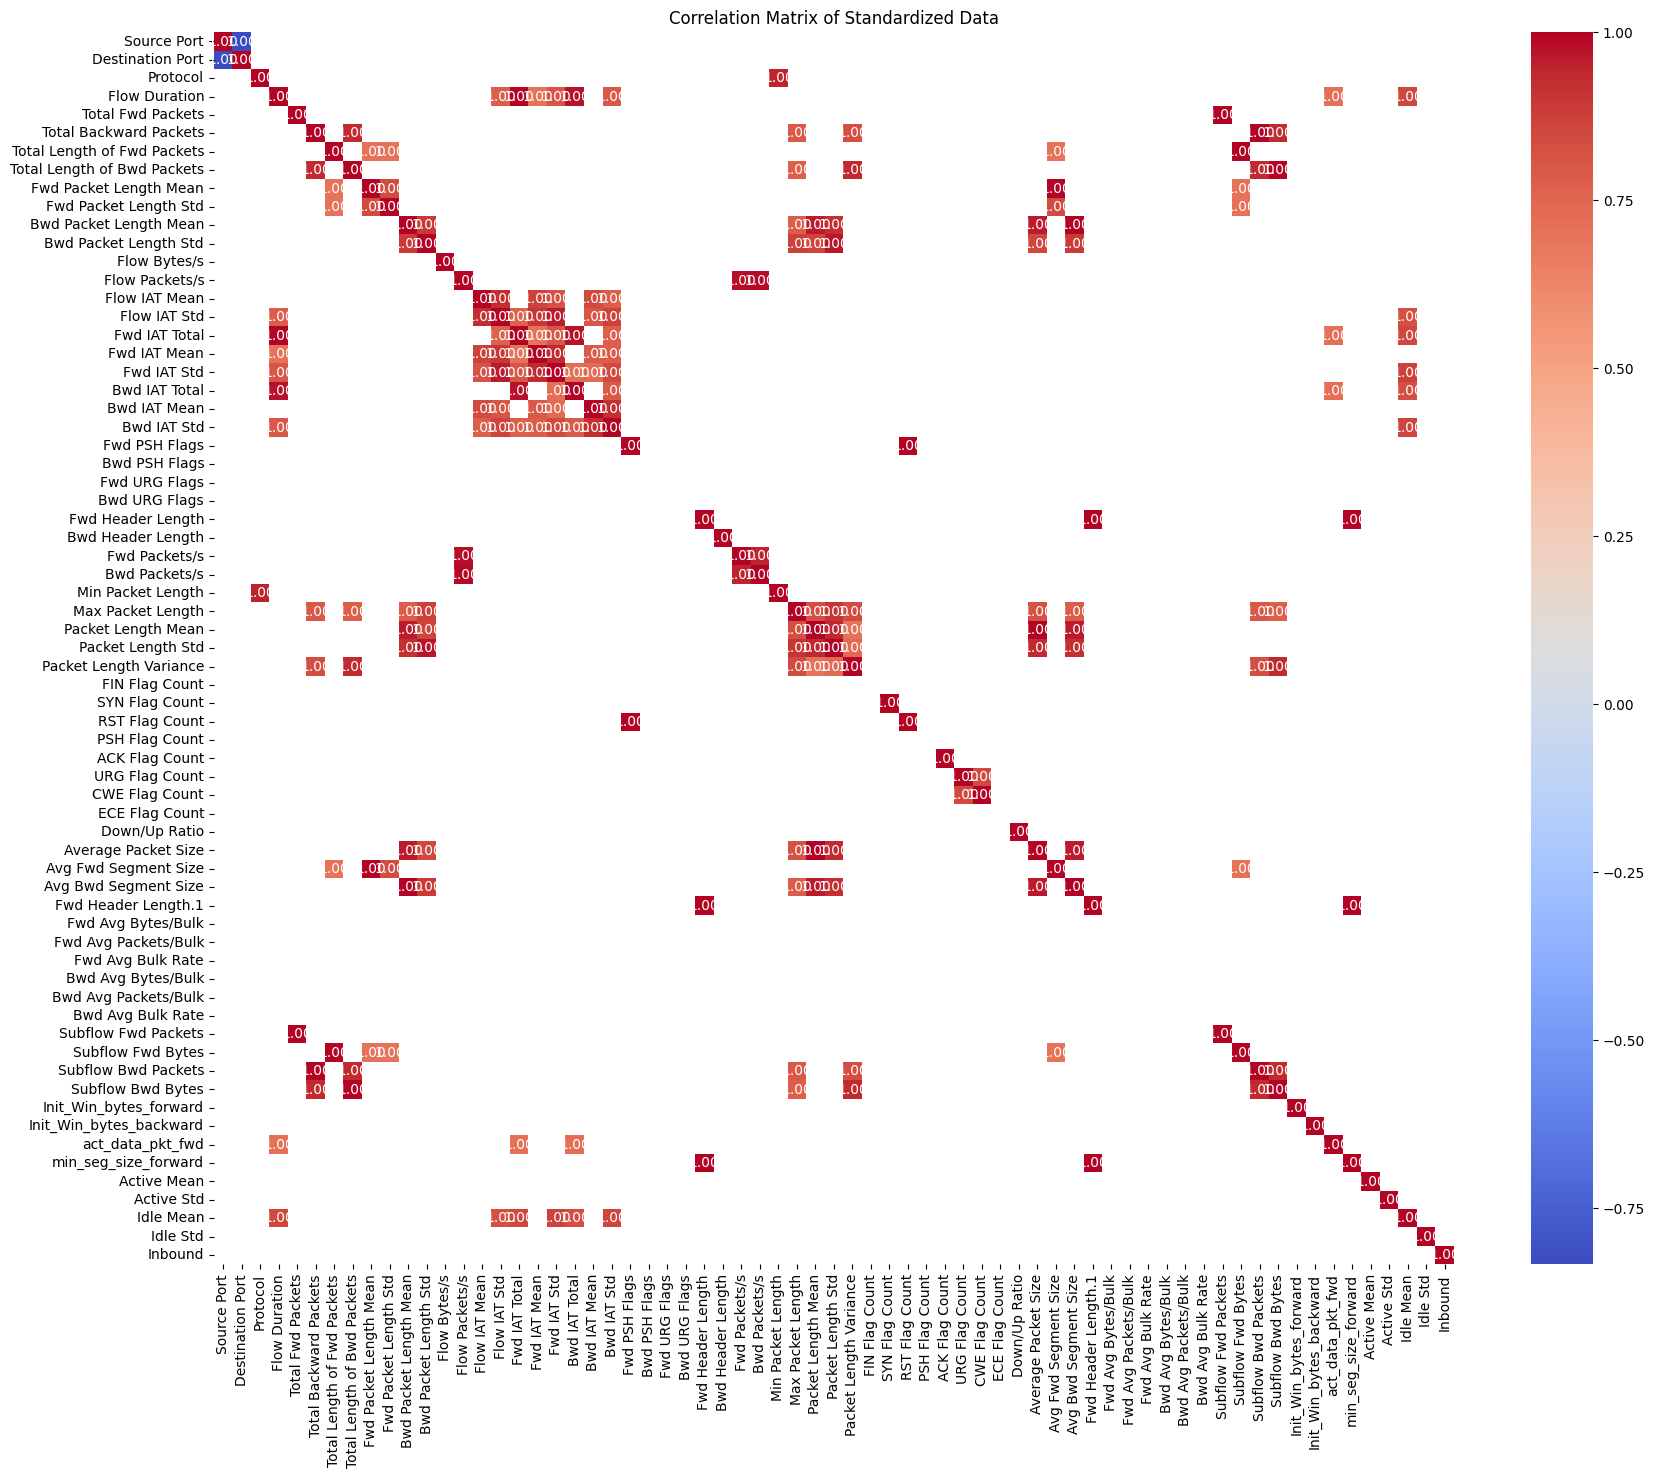

Completed: Heatmap of correlations displayed.
Starting: Displaying the clustermap...


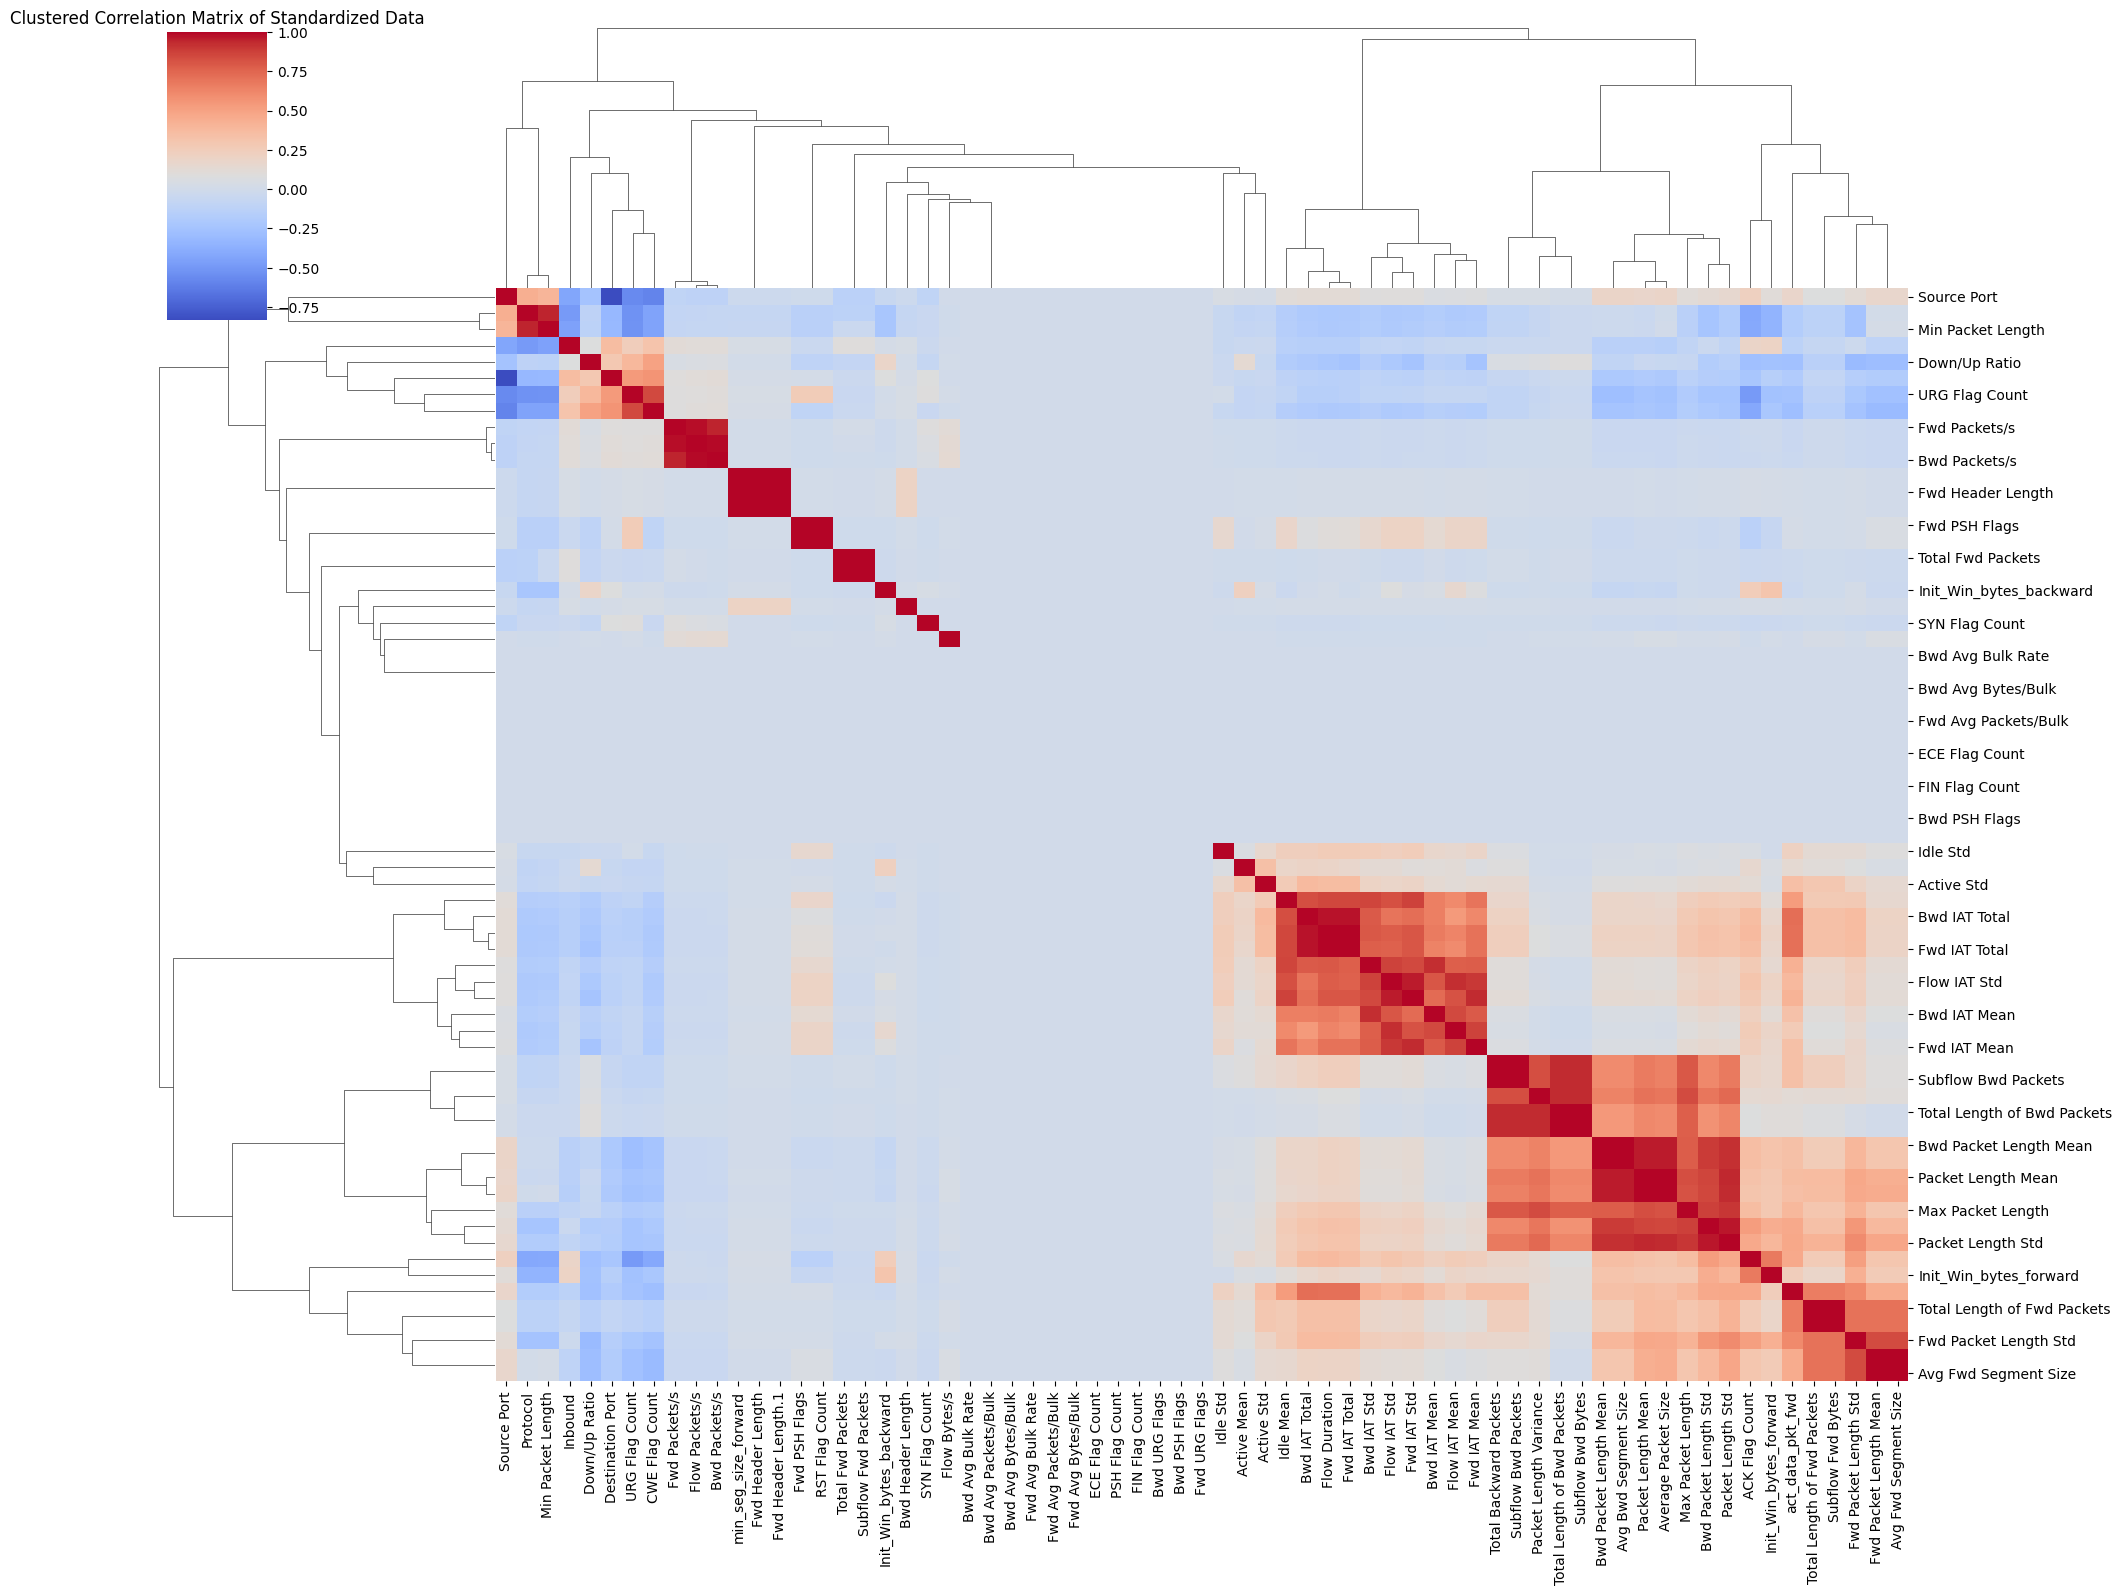

Completed: Clustermap displayed.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Alert: Starting the data loading process
print("Starting: Loading the dataset...")

# Load the datasets
df_netbios = pd.read_csv("cicids2019/DrDoS_NetBIOS_data_1_3_per.csv", low_memory=False)
df_ntp = pd.read_csv("cicids2019/DrDoS_NTP_data_data_5_per.csv", low_memory=False)
df_snmp = pd.read_csv("cicids2019/DrDoS_SNMP_data_1_3_per.csv", low_memory=False)

# Combine the datasets
df = pd.concat([df_netbios, df_ntp, df_snmp])

# Strip leading/trailing whitespace from column names
df.columns = df.columns.str.strip()

# Print column names to verify
print("Column names after stripping whitespace:")
print(df.columns.tolist())

# Separate the 'Label' column as the target variable
target = df['Label']

# Encode the 'Label' column (for multi-class classification)
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Drop the 'Unnamed: 0', 'Flow ID', and highly correlated min/max columns
df = df.drop(columns=[
    'Unnamed: 0', 'Flow ID', 'Label', 'Fwd Packet Length Min', 'Fwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Max', 
    'Flow IAT Min', 'Flow IAT Max', 'Fwd IAT Min', 'Fwd IAT Max', 'Bwd IAT Min', 'Bwd IAT Max', 'Active Min', 'Active Max', 'Idle Min', 'Idle Max'])

# Alert: Dataset loaded successfully
print("Completed: Datasets loaded successfully.")

# Handle duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
df = df.drop_duplicates()

# Handling missing values by replacing infinity values with NaN (Not a number placeholder)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove rows with more than 30% missing values
df = df.dropna(thresh=int(0.7 * df.shape[1])) # keeps rows with at least 70% non-NaN data

# Select only numeric columns for filling NaN values
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Remove irrelevant rows where 'Total Fwd Packets' or 'Total Backward Packets' are zero
df = df[(df['Total Fwd Packets'] > 0) & (df['Total Backward Packets'] > 0)]

# Select numerical features for scaling
numerical_features = df.select_dtypes(include=[np.number])

# Apply normalization (Min-Max scaling)
min_max_scaler = MinMaxScaler()
df_normalized = pd.DataFrame(min_max_scaler.fit_transform(numerical_features), columns=numerical_features.columns)

# Apply standardization (Z-score normalization)
standard_scaler = StandardScaler()
df_standardized = pd.DataFrame(standard_scaler.fit_transform(numerical_features), columns=numerical_features.columns)

# Print the first few rows of normalized and standardized data
print("First few rows of Normalized Data (Min-Max Scaling):")
print(df_normalized.head())

print("\nFirst few rows of Standardized Data (Z-score):")
print(df_standardized.head())

# Alert: Calculating the correlation matrix
print("Starting: Calculating correlation matrix on standardized data...")

# Calculate the correlation matrix on the standardized data
correlation_matrix = df_standardized.corr()

# Handle infinite or NaN values by filling them with 0 or dropping them
correlation_matrix = correlation_matrix.replace([np.inf, -np.inf], np.nan).fillna(0)

# Alert: Correlation matrix calculation complete
print("Completed: Correlation matrix calculated.")

# Alert: Displaying the heatmap of correlations
print("Starting: Displaying the heatmap of correlations...")

# Display the heatmap of correlations
plt.figure(figsize=(20, 16))

# Annotate correlations above 0.7 or below -0.7
mask = np.abs(correlation_matrix) >= 0.7
sns.heatmap(correlation_matrix, annot=mask, fmt=".2f", cmap='coolwarm', mask=~mask, cbar=True)

plt.title('Correlation Matrix of Standardized Data')
plt.show()

# Alert: Heatmap displayed
print("Completed: Heatmap of correlations displayed.")

# Alert: Displaying the clustermap
print("Starting: Displaying the clustermap...")

# Display the clustermap
sns.clustermap(correlation_matrix, annot=False, cmap='coolwarm', figsize=(20, 16))
plt.title('Clustered Correlation Matrix of Standardized Data')
plt.show()

# Alert: Clustermap displayed
print("Completed: Clustermap displayed.")